In [2]:
import sympy
import numpy as np
from sympy.interactive.printing import init_printing
from sympy.matrices import Matrix, zeros
from sympy import symbols
init_printing()

In [3]:
class system():
    """
    
    """
    def __init__(self, lambda_count, v_count, need_g = False, start_computing = True, find_lambdas = False):
        self.need_g = need_g
        self.dimension = 3**(lambda_count+v_count)
        self.coef = symbols('lambda0:'+str(self.dimension))
        self.lambda_count = lambda_count
        self.v_count = v_count
        self.families = []
        self.M = Matrix()
        self.M_rank = 0
        self.nullspace = []
        self.states = []
        self.lambdas = []
        for i in range(self.dimension):
            self.states.append(system.th(i, lambda_count+v_count))
        self.gw = symbols('g1:'+str(self.lambda_count+self.v_count+1)+'_omega')
        self.gW = symbols('g1:'+str(self.lambda_count+self.v_count+1)+'_Omega')
        self.g = self.gw + self.gW
        if(start_computing):
            self.create_families()
            self.create_M()
            self.create_nullspace()
            self.basis = self.get_basis()
            #Крайне негативно сказывается на скорости выполнения - решение нелинейной системы уравнений
            if(find_lambdas):
                self.lambdas = self.create_lambda()

            
    def __str__(self):
        """
        Обработка текстового вывода общего вида системы
        """
        result = ''
        for i in range(len(self.states)-1):
            result+=(repr(self.coef[i]) + '|' + self.states[i] + '> + ')
        return result+ repr(self.coef[i+1]) +'|'+self.states[i+1]+'>'
    
    @staticmethod
    def th(num, count = 0):
        """
        Функция перевода числа в троичную систему счисления с заданной длиной числа (количеством незнячащих нулей)
        """
        base = 3
        new_num = ''
        zero_new_num = ''
        while num > 0:
            new_num = str(num % base) + new_num
            num //= base
        #В этом месте переменная new_num содержит переведенное число из десятичной системы в троичную
        for i in range(count - len(new_num)):
            zero_new_num+='0'
        zero_new_num+=new_num
        #Тип возвращаемого результата - строка (для избежания удаления незначащих нулей в начале числа)
        return zero_new_num
    
    def create_families(self):
        """
        Функция заполняет список families, вызывается только в конструкторе
        """
        for state in range(len(self.states)):
            family_o = [] #Семья по переходу вида омега малая
            for l_number in range(self.lambda_count):
                """
                переход 2 -> 1 для лямбда-типа атомов
                """
                if(self.states[state][l_number] == '1'):
                    family_o.append(self.states[state][:l_number]+
                                    '2'+self.states[state][l_number+1:])
            for v_number in range(self.v_count):
                """
                переход 1 -> 2 для v-типа атомов
                """
                if(self.states[state][self.lambda_count+v_number] == '0'):
                    family_o.append(self.states[state][:self.lambda_count+v_number]+
                                    '1'+self.states[state][self.lambda_count+v_number+1:])
            self.families.append(family_o)
            family_O = [] #Семья по переходу вида омега большая
            for l_number in range(self.lambda_count):
                """
                переход 2 -> 0 для лямбда-типа атомов
                """
                if(self.states[state][l_number] == '0'):
                    family_O.append(self.states[state][:l_number]+
                                    '2'+self.states[state][l_number+1:])
            for v_number in range(self.v_count):
                """
                переход 2 -> 0 для v-типа атомов
                """
                if(self.states[state][self.lambda_count+v_number] == '0'):
                    family_O.append(self.states[state][:self.lambda_count+v_number]+
                                    '2'+self.states[state][self.lambda_count+v_number+1:])
                    
            self.families.append(family_O)

    def create_M(self):
        """
        Функция вызывается только в конструкторе
        Создает матрицу, определяющую систему уравнений относительно лямбда и вычисляет ее ранг
        """
        self.M = zeros(2*self.dimension, self.dimension)
        for row in range(2*self.dimension):
            for col in range(self.dimension):
                if(system.th(col, self.lambda_count+self.v_count) in self.families[row]):
                    
                    """
                    !!!Поскольку в рамках задачи значения g i-ых не влияют на ранг матрицы, принимаем их все равными 1
                    """
                    if(not self.need_g):
                        self.M[row, col] = 1
                    else:
                        if(row%2==0):
                            sd = 0
                            for i in range(self.lambda_count+self.v_count):
                                if(self.th(row, self.lambda_count+self.v_count)[i] != 
                                   self.th(col, self.lambda_count+self.v_count)[i]):
                                    sd = i
                            self.M[row, col] = self.g[sd]
                        else:
                            sd = 0
                            for i in range(self.lambda_count+self.v_count):
                                if(self.th(int(row/2), self.lambda_count+self.v_count)[i] != 
                                   self.th(col, self.lambda_count+self.v_count)[i]):
                                    sd = i
                            self.M[row, col] = self.g[self.lambda_count+self.v_count+sd]
        self.M_rank = self.M.rank()

        
    def create_nullspace(self):
        #Решение однородной СЛАУ - ядро матрицы коэффициентов:
        self.nullspace = self.M.nullspace()
        
        
    def darksubspace_dimension(self):
        """
        Возвращает размерность подпространства темных состояний
        """
        return self.dimension - self.M_rank
    
    def get_basis(self):
        coefs = Matrix(self.coef).T
        result = []
        for i in range(len(self.nullspace)):
            result.append((coefs*self.nullspace[i])[0])
        self.basis = result
        return result
    
    def get_basis_vectors(self):
        result = []   
        coefs = Matrix(self.coef)
        for i in range(self.dimension - self.M_rank):
            result.append(coefs.multiply_elementwise(self.nullspace[i]))
        return result    

    def create_lambda(self):
        s1 = self.get_basis_vectors()
        result = []
        coefs = Matrix(self.coef).T
        for i in range(self.darksubspace_dimension()):
            eq = 0
            for j in range(self.dimension):
                eq += s1[i][j]**2
            result.append(sympy.Eq(eq, 1))
        return sympy.solve(result, self.coef, dict = True)
    
    
    #Отладочная по сути функция для быстрого получения результата
    #Работает только при условии что need_g = False
    def get_basis_text(self):
        result = []
        for i in range(self.dimension - self.M_rank):
            vector = ""
            for j in range(self.dimension):
                if(self.nullspace[i][j] == -1):
                    vector += ('-' + self.th(j, self.lambda_count+self.v_count))
                if(self.nullspace[i][j] == 1):
                    vector += ('+' + self.th(j, self.lambda_count+self.v_count))
            if(len(vector) != self.lambda_count+self.v_count+1):
                result.append(vector)
            else:
                result.append(vector[1:])
        return(result)


# Вычисления

In [5]:
s = system(lambda_count = 1, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

In [6]:
#Размерность подпространства темных состояний:
s.darksubspace_dimension()

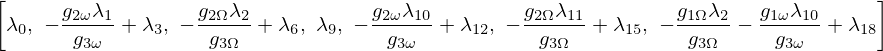

In [7]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s.basis

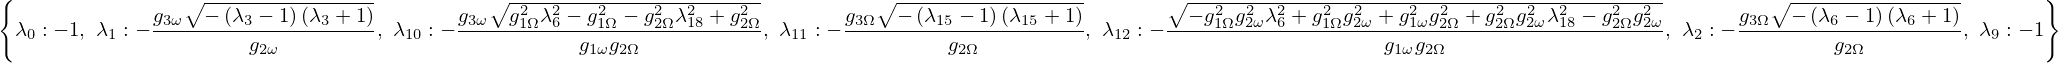

In [8]:
#Решение системы нелинейных уравнений (критерий нормировки):
s.lambdas[0]

## 2 атома

### 2lambda + 0v

In [3]:
s20 = system(lambda_count = 2, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

In [4]:
#Размерность подпространства темных состояний:
s20.darksubspace_dimension()

In [5]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s20.basis

In [6]:
#Решение системы нелинейных уравнений (критерий нормировки):
s20.lambdas[0]

In [7]:
#Время вычисления полностью
%timeit system(lambda_count = 2, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

45.5 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 2, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

16.8 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 2, v_count = 0, need_g = False, start_computing = True, find_lambdas = False)

3.31 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 1lambda + 1v

In [10]:
s11 = system(lambda_count = 1, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

In [11]:
#Размерность подпространства темных состояний:
s11.darksubspace_dimension()

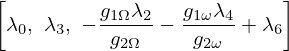

In [12]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s11.basis

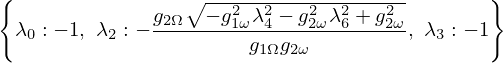

In [13]:
#Решение системы нелинейных уравнений (критерий нормировки):
s11.lambdas[0]

In [14]:
#Время вычисления полностью
%timeit system(lambda_count = 1, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

87.5 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 1, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

3.66 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 1, v_count = 1, need_g = False, start_computing = True, find_lambdas = False)

3.19 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 0lambda + 2v

In [17]:
s02 = system(lambda_count = 0, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

In [18]:
#Размерность подпространства темных состояний:
s02.darksubspace_dimension()

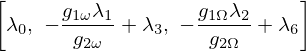

In [19]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s02.basis

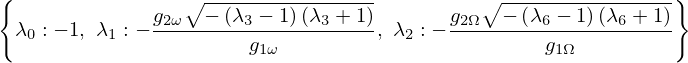

In [20]:
#Решение системы нелинейных уравнений (критерий нормировки):
s02.lambdas[0]

In [21]:
#Время вычисления полностью
%timeit system(lambda_count = 0, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

96.2 ms ± 721 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 0, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

3.66 ms ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 0, v_count = 2, need_g = False, start_computing = True, find_lambdas = False)

3.23 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 3 атома

### 3lambda + 0v

In [24]:
s30 = system(lambda_count = 3, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

In [25]:
#Размерность подпространства темных состояний:
s30.darksubspace_dimension()

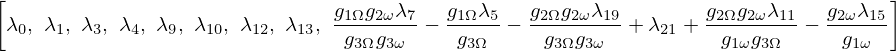

In [26]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s30.basis

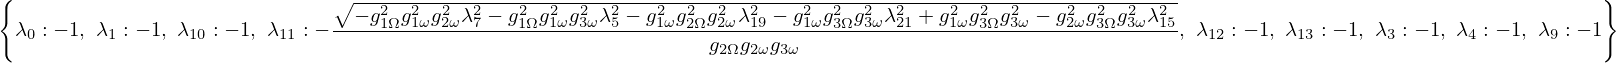

In [27]:
#Решение системы нелинейных уравнений (критерий нормировки):
s30.lambdas[0]

In [28]:
#Время вычисления полностью
%timeit system(lambda_count = 3, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

51.5 s ± 970 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 3, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

161 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 3, v_count = 0, need_g = False, start_computing = True, find_lambdas = False)

28.5 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 2lambda + 1v

In [31]:
s21 = system(lambda_count = 2, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

In [32]:
#Размерность подпространства темных состояний:
s21.darksubspace_dimension()

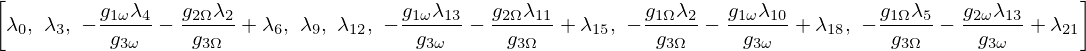

In [33]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s21.basis

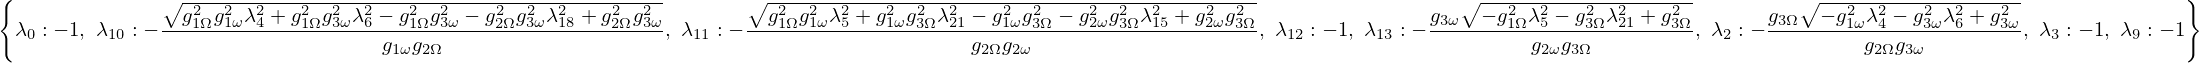

In [34]:
#Решение системы нелинейных уравнений (критерий нормировки):
s21.lambdas[0]

In [35]:
λ#Время вычисления полностью
%timeit system(lambda_count = 2, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

2min 19s ± 2.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 2, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

95.3 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 2, v_count = 1, need_g = False, start_computing = True, find_lambdas = False)

27.1 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1lambda + 2v

In [38]:
s12 = system(lambda_count = 1, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

In [39]:
#Размерность подпространства темных состояний:
s12.darksubspace_dimension()

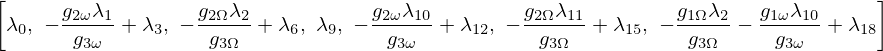

In [40]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s12.basis

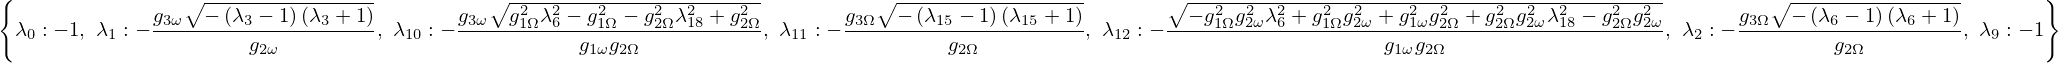

In [41]:
#Решение системы нелинейных уравнений (критерий нормировки):
s12.lambdas[0]

In [42]:
#Время вычисления полностью
%timeit system(lambda_count = 1, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

17.9 s ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 1, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

107 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 1, v_count = 2, need_g = False, start_computing = True, find_lambdas = False)

27 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 0lambda + 3v

In [45]:
s03 = system(lambda_count = 0, v_count = 3, need_g = True, start_computing = True, find_lambdas = True)

In [46]:
#Размерность подпространства темных состояний:
s03.darksubspace_dimension()

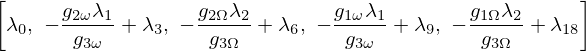

In [47]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s03.basis

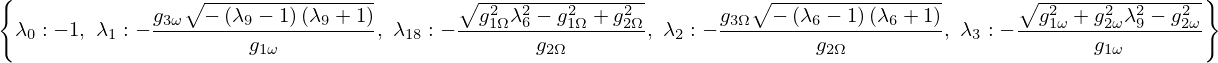

In [48]:
#Решение системы нелинейных уравнений (критерий нормировки):
s03.lambdas[0]

In [49]:
#Время вычисления полностью
%timeit system(lambda_count = 0, v_count = 3, need_g = True, start_computing = True, find_lambdas = True)

1.28 s ± 9.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 0, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

369 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 0, v_count = 3, need_g = False, start_computing = True, find_lambdas = False)

26.1 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 4 атома

### 4lambda + 0v

In [3]:
s40 = system(lambda_count = 4, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

In [4]:
#Размерность подпространства темных состояний:
s40.darksubspace_dimension()

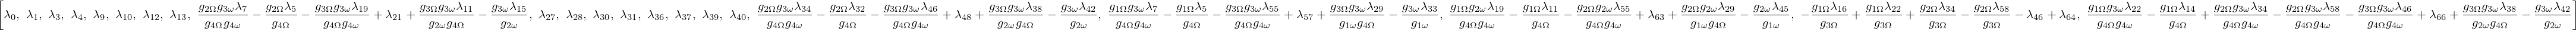

In [5]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s40.basis

In [6]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s40.lambdas[0]

In [7]:
#Время вычисления полностью
#%timeit system(lambda_count = 4, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

In [8]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 4, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

2.19 s ± 42.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 4, v_count = 0, need_g = False, start_computing = True, find_lambdas = False)

286 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3lambda + 1v

In [10]:
s31 = system(lambda_count = 3, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

In [11]:
#Размерность подпространства темных состояний:
s31.darksubspace_dimension()

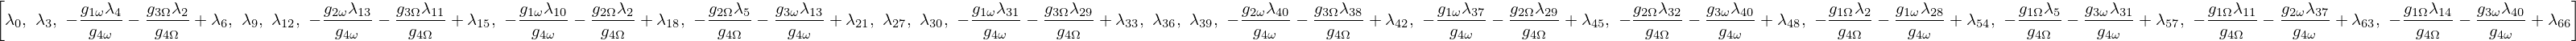

In [12]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s31.basis

In [13]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s31.lambdas[0]

In [14]:
#Время вычисления полностью
#%timeit system(lambda_count = 3, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

In [15]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 3, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

2.3 s ± 77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 3, v_count = 1, need_g = False, start_computing = True, find_lambdas = False)

266 ms ± 939 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2lambda + 2v

In [17]:
s22 = system(lambda_count = 2, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

In [18]:
#Размерность подпространства темных состояний:
s22.darksubspace_dimension()

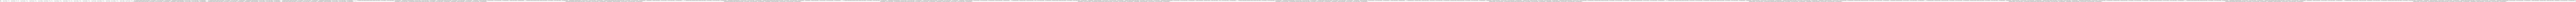

In [19]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s22.basis

In [20]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s22.lambdas[0]

In [21]:
#Время вычисления полностью
#%timeit system(lambda_count = 2, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

In [22]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 2, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

2.27 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 2, v_count = 2, need_g = False, start_computing = True, find_lambdas = False)

264 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1lambda + 3v

In [24]:
s13 = system(lambda_count = 1, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

In [25]:
#Размерность подпространства темных состояний:
s13.darksubspace_dimension()

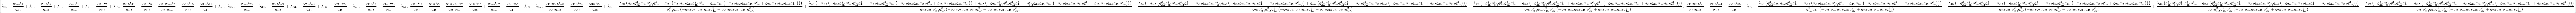

In [26]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s13.basis

In [27]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s13.lambdas[0]

In [28]:
#Время вычисления полностью
#%timeit system(lambda_count = 1, v_count = 3, need_g = True, start_computing = True, find_lambdas = True)

In [29]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 1, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

1.97 s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 1, v_count = 3, need_g = False, start_computing = True, find_lambdas = False)

252 ms ± 6.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 0lambda + 4v

In [31]:
s04 = system(lambda_count = 0, v_count = 4, need_g = True, start_computing = True, find_lambdas = False)

In [32]:
#Размерность подпространства темных состояний:
s04.darksubspace_dimension()

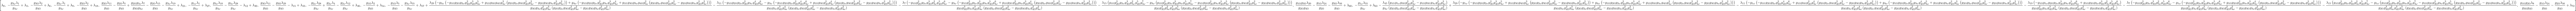

In [33]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s04.basis

In [34]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s04.lambdas[0]

In [35]:
#Время вычисления полностью
#%timeit system(lambda_count = 0, v_count = 4, need_g = True, start_computing = True, find_lambdas = True)

In [36]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 0, v_count = 4, need_g = True, start_computing = True, find_lambdas = False)

2.79 s ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 0, v_count = 4, need_g = False, start_computing = True, find_lambdas = False)

262 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 5 атомов

### 5lambda + 0v

In [38]:
s50 = system(lambda_count = 5, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

In [39]:
#Размерность подпространства темных состояний:
s50.darksubspace_dimension()

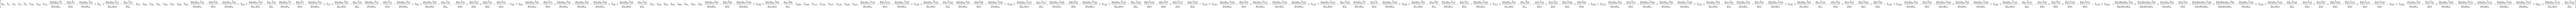

In [40]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s50.basis

In [41]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s50.lambdas[0]

In [42]:
#Время вычисления полностью
#%timeit system(lambda_count = 5, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

In [43]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 5, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

2min 40s ± 4.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 5, v_count = 0, need_g = False, start_computing = True, find_lambdas = False)

4 s ± 405 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 4lambda + 1v

In [ ]:
s41 = system(lambda_count = 4, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s41.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s41.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s41.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 4, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 4, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 4, v_count = 1, need_g = False, start_computing = True, find_lambdas = False)

### 3lambda + 2v

In [ ]:
s32 = system(lambda_count = 3, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s32.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s32.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s32.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 3, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 3, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 3, v_count = 2, need_g = False, start_computing = True, find_lambdas = False)

### 2lambda + 3v

In [ ]:
s23 = system(lambda_count = 2, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s23.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s23.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s23.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 2, v_count = 3, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 2, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 2, v_count = 3, need_g = False, start_computing = True, find_lambdas = False)

### 1lambda + 4v

In [ ]:
s14 = system(lambda_count = 1, v_count = 4, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s14.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s14.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s14.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 1, v_count = 4, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 1, v_count = 4, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 1, v_count = 4, need_g = False, start_computing = True, find_lambdas = False)

### 0lambda + 5v

In [ ]:
s05 = system(lambda_count = 0, v_count = 5, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s05.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s05.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s05.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 0, v_count = 5, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 0, v_count = 5, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 0, v_count = 5, need_g = False, start_computing = True, find_lambdas = False)

## 6 атомов

### 6lambda + 0v

In [ ]:
s60 = system(lambda_count = 6, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s60.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s60.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s60.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 6, v_count = 0, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 6, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 6, v_count = 0, need_g = False, start_computing = True, find_lambdas = False)

### 5lambda + 1v

In [ ]:
s51 = system(lambda_count = 5, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s51.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s51.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s51.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 5, v_count = 1, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 5, v_count = 1, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 5, v_count = 1, need_g = False, start_computing = True, find_lambdas = False)

### 4lambda + 2v

In [ ]:
s42 = system(lambda_count = 4, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s42.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s42.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s42.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 4, v_count = 2, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 4, v_count = 2, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 4, v_count = 2, need_g = False, start_computing = True, find_lambdas = False)

### 3lambda + 3v

In [ ]:
s33 = system(lambda_count = 3, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s33.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s33.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s33.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 3, v_count = 3, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 3, v_count = 3, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 3, v_count = 3, need_g = False, start_computing = True, find_lambdas = False)

### 2lambda + 4v

In [ ]:
s24 = system(lambda_count = 2, v_count = 4, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s24.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s24.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s24.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 2, v_count = 4, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 2, v_count = 4, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 2, v_count = 4, need_g = False, start_computing = True, find_lambdas = False)

### 1lambda + 5v

In [ ]:
s15 = system(lambda_count = 1, v_count = 5, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s15.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s15.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s15.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 1, v_count = 5, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 1, v_count = 5, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 1, v_count = 5, need_g = False, start_computing = True, find_lambdas = False)

### 0lambda + 6v

In [ ]:
s06 = system(lambda_count = 0, v_count = 6, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Размерность подпространства темных состояний:
s06.darksubspace_dimension()

In [ ]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s06.basis

In [ ]:
#Решение системы нелинейных уравнений (критерий нормировки):
#s06.lambdas[0]

In [ ]:
#Время вычисления полностью
#%timeit system(lambda_count = 0, v_count = 6, need_g = True, start_computing = True, find_lambdas = True)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки
%timeit system(lambda_count = 0, v_count = 6, need_g = True, start_computing = True, find_lambdas = False)

In [ ]:
#Время вычисления без нахождения коэффициентов нормировки и без учета g
%timeit system(lambda_count = 0, v_count = 6, need_g = False, start_computing = True, find_lambdas = False)

# test 7 atoms

In [ ]:
s70 = system(lambda_count = 7, v_count = 0, need_g = True, start_computing = True, find_lambdas = False)
s07 = system(lambda_count = 0, v_count = 7, need_g = True, start_computing = True, find_lambdas = False)